In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")

In [ ]:
from langchain_core.prompts import ChatPromptTemplate


assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "you are the assistant, heliping reservation puppy haircut"
            ""
            "response is always say korean"
        ),
        ("placeholder", "{messages}"),
    ]
)

In [24]:
%pip install langchain_upstage langchain_pinecone

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 46.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.11.9
    Uninstalling aiohttp-3.11.9:
      Successfully uninstalled aiohttp-3.11.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
realtime 2.0.6 requires aiohttp<4.0.0,>=3.10.10, but you have aiohttp 3.9.5 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [21]:
# csv 파일 불러오기
from langchain_community.document_loaders.csv_loader import CSVLoader

breeds_file_path = "csv/breeds.csv"
service_file_path = "csv/services.csv"

breeds_loader = CSVLoader(breeds_file_path)
service_loader = CSVLoader(service_file_path)

breeds_data = breeds_loader.load()
service_data = service_loader.load()

In [22]:
from dotenv import load_dotenv
import os
from langchain_upstage import UpstageEmbeddings
from supabase import create_client, Client

load_dotenv()
UPSTAGE_API_KEY = os.getenv("UPSTAGE_API_KEY")
embedding = UpstageEmbeddings(
    api_key=UPSTAGE_API_KEY,
    model="embedding-query"
)

SUPABASE_URL = os.getenv("SUPABASE_URL")
SUPABASE_KEY = os.getenv("SUPABASE_KEY")
supabase: Client = create_client(SUPABASE_URL, SUPABASE_KEY)

In [25]:
from langchain_pinecone import PineconeVectorStore


breeds_database_index = "breeds"
# # 벡터 저장소 생성
# breed_database = PineconeVectorStore.from_documents(
# 	documents=breeds_data,
# 	embedding=embedding,
# 	index_name=breeds_database_index
# )

service_database_index = "services"
# # 벡터 저장소 생성
# service_database = PineconeVectorStore.from_documents(
# 	documents=service_data,
# 	embedding=embedding,
# 	index_name=service_database_index
# )

breeds_database = PineconeVectorStore(index_name=breeds_database_index, embedding=embedding)
service_database = PineconeVectorStore(index_name=service_database_index, embedding=embedding)

/opt/anaconda3/envs/test/lib/python3.12/site-packages/pinecone/data/index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [26]:
# Pydantic을 사용하여 정보 추출

from typing import Optional
from pydantic import BaseModel, Field

class Pet(BaseModel):
    """Information about a pet"""
    # ^ Doc-string for the entity Pet
    # This doc-string is sent to the LLM as the description of the schema Pet,
    # and it can help to improve extraction results.

    # Note that:
    # 1. Each field is an `optional` -- this allows the model to decline to extract it!
    # 2. `weight` and `breedType` are required fields and must be provided during validation.
    # 3. Each field has a `description` -- this description is used by the LLM.
    # Having a good description can help improve extraction results.
    name: Optional[str] = Field(description="The name of the pet")
    breedType: Optional[str] = Field(description="The type of the breed")
    breed: Optional[str] = Field(description="The breed of the pet")
    weight: Optional[float] = Field(description="The weight of the pet")
    age: Optional[int] = Field(description="The age of the pet")


structured_llm = llm.with_structured_output(schema=Pet)

In [27]:
# Extractor
from langchain_core.prompts import ChatPromptTemplate

# Define a custom prompt to provide instructions and any additional context.
# 1) You can add examples into the prompt template to improve extraction quality
# 2) Introduce additional parameters to take context into account (e.g., include metadata
#    about the document from which the text was extracted.)
prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert extraction algorithm. "
            "Only extract relevant information from the text. "
            "If you do not know the value of an attribute asked to extract, "
            "return null for the attribute's value.",
        ),
        # Please see the how-to about improving performance with
        # reference examples.
        # MessagesPlaceholder('examples'),
        ("human", "{text}"),
    ]
)

# BreedType Extractor
def fill_breed_type(query: str, retrieved_docs):
    prompt = prompt_template.invoke({"text": query})
    extracted_pet: Pet = structured_llm.invoke(prompt)
    breed_type_info = None
    for doc in retrieved_docs:
        # 각 문서의 page_content에서 name과 type을 파싱
        lines = doc.page_content.split('\n')
        name_line = next((line for line in lines if line.startswith("name:")), None)
        type_line = next((line for line in lines if line.startswith("type:")), None)
        breed = name_line.split(":")[-1].strip()  # name 값 추출
        breed_type_info = type_line.split(":")[-1].strip()  # type 값 추출
    if breed:
        extracted_pet.breed = breed
    if breed_type_info:
        extracted_pet.breedType = breed_type_info
    return extracted_pet


# test
query = "내 강아지 티미고 말티고 6.5kg이야 3살이야 미용하고싶은데 얼마야?"
retrieved_docs = breeds_database.similarity_search(query, k=1)
extracted_pet = fill_breed_type(query, retrieved_docs)

In [28]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

weight_dictionary = [
	"4kg 이하 -> weight_range=1",
	"4kg 이상 6kg 이하 -> weight_range=2",
	"6kg 이상 8kg 이하 -> weight_range=3",
	"8kg 이상 10kg 이하 -> weight_range=4"
]

service_prompt = ChatPromptTemplate.from_template("""
    you are an expert in pet services.
    you can help you find the price of a service for your pet.
    주어지는 petInfo를 적극 활용해주세요.
    [pet_info]
    {pet_info}
    [weight_dictionary]
    {weight_dictionary}
    다음과 같은 요구사항이 있습니다
    1. weight_dictionary를 참고해서 weight를 weight_range로 바꿔주세요
    2. 다른 설명은 하지 마시고, weight_range의 숫자만 출력해주세요
    ex) weight_range=1 이라면 1만
""")

chain = service_prompt | llm | StrOutputParser()


In [29]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

def get_service_by_breed_and_weight(breed_type: int, weight_range: int):
	response = supabase.rpc(
		"get_services_by_breed_and_weight",
		{
			"breed_type_id": breed_type,
			"weight_range_id": weight_range
		}
	).execute()
	return response

def create_rerservation(
    pet_id: str,
    memo: str,
    status: str,
    reservation_date: str,
    price: int,
    service_name: str,
    additional_service_name: str,
    inquiry: str,
    weight: float,
    service_id: int,
    service_option_ids: str,
):
    response = supabase.rpc(
        "create_reservation",
        {
            "pet_id":pet_id,
            "memo":memo,
            "status":status,
            "reservation_date":reservation_date,
            "price":price,
            "service_name":service_name,
            "additional_service_name":additional_service_name,
            "inquiry":inquiry,
            "weight":weight,
            "service_id":service_id,
            "service_option_ids":service_option_ids
        }
    ).execute()
    return response

@tool
def get_service_menu(query: str):
    """
    Retrieves the available services based on the provided query describing the pet.

    Steps:
    1. Extracts pet information such as breed type, weight, and other attributes.
    2. Maps the weight to the appropriate weight range using the weight dictionary.
    3. Fetches the services available for the given breed type and weight range from the database.

    Note:
        - This tool must be used to select services when making a grooming reservation for your pet.
        - Without using this tool, it is not possible to proceed with a grooming reservation as it ensures
          accurate matching of services based on the pet's breed type and weight range.

    """
    # Step 1: Pet 정보 추출
    retrieved_docs = breeds_database.similarity_search(query, k=1)
    extracted_pet = fill_breed_type(query, retrieved_docs)
    weight_range = chain.invoke({"pet_info": extracted_pet, "weight_dictionary": weight_dictionary})
    weight_range = int(weight_range)
    breed_type = int(extracted_pet.breedType) if extracted_pet.breedType else 0
    service_data = get_service_by_breed_and_weight(breed_type, weight_range)
    return service_data

@tool
def make_reservation(
    reservation_date: str,
    price: int,
    service_name: str,
    weight: float,
    service_id: int,
):
    """
    Creates a reservation for a pet grooming service.

    Steps:
    1. Creates a reservation for the provided pet with the specified service
    2. Returns the reservation details.

    Note:
        - This tool must be used to create a grooming
            reservation for your pet after selecting the services using the `get_service_menu` tool.
        - Without using this tool, it is not possible to proceed with a grooming reservation.
    """
    response = create_rerservation(
        pet_id=None,
        memo=None,
        status="예약대기",
        reservation_date=reservation_date,
        price=price,
        service_name=service_name,
        additional_service_name=None,
        inquiry=None,
        weight=weight,
        service_id=service_id,
        service_option_ids=None,
    )
    return response

tools = [get_service_menu, make_reservation]
llm_with_tools = llm.bind_tools(tools)
tool_node = ToolNode(tools=tools)



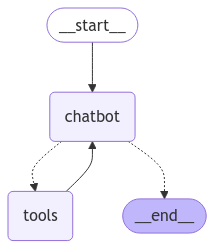

In [30]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [ ]:

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break


# TODO: 1. 대형견
# TODO: 2. 예약 로직 추가

Assistant: 
Assistant: data=[{'service_id': 13, 'service_name': '위생미용+목욕', 'price': 50000}, {'service_id': 14, 'service_name': '클리핑', 'price': 60000}, {'service_id': 15, 'service_name': '스포팅', 'price': 80000}, {'service_id': 16, 'service_name': '가위컷', 'price': 90000}, {'service_id': 52, 'service_name': '위생미용', 'price': 15000}] count=None
Assistant: 예약할 수 있는 서비스는 다음과 같습니다:

1. **위생미용+목욕** - 50,000원
2. **클리핑** - 60,000원
3. **스포팅** - 80,000원
4. **가위컷** - 90,000원
5. **위생미용** - 15,000원

원하는 서비스를 선택해 주시면 예약을 진행하겠습니다!
Assistant: 
Assistant: data=[{'service_id': 37, 'service_name': '위생미용+목욕', 'price': 40000}, {'service_id': 38, 'service_name': '클리핑', 'price': 50000}, {'service_id': 39, 'service_name': '스포팅', 'price': 90000}, {'service_id': 40, 'service_name': '가위컷', 'price': 100000}, {'service_id': 58, 'service_name': '위생미용', 'price': 15000}] count=None
Assistant: 여기 5번에 해당하는 서비스 메뉴가 있습니다:

1. **위생미용+목욕** - 40,000원
2. **클리핑** - 50,000원
3. **스포팅** - 90,000원
4. **가위컷** - 100,000원
5. **위생미용** - 1